In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit    

In [15]:
def SpinChain(n,J,h):
    X = np.array([[0, 1], [1, 0]],dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]],dtype=complex)
    Z = np.array([[1, 0], [0, -1]],dtype=complex)
    def hopping(P,i):
        assert i < n, "i should be less than n"
        if i == 0 or i == n-1:
            matrix = P
        else:
            matrix = np.eye(2,dtype=complex)
        for j in range(1,n):
            if j == i or j == i+1:
                matrix = np.kron(P,matrix)
            else:
                matrix = np.kron(np.eye(2,dtype=complex),matrix)
        return matrix
    def potential(P,i):
        assert i < n, "i should be less than n"
        if i == 0:
            matrix = P
        else:
            matrix = np.eye(2,dtype=complex)
        for j in range(1,n):
            if j == i:
                matrix = np.kron(P,matrix)
            else:
                matrix = np.kron(np.eye(2,dtype=complex),matrix)
        return matrix
    
    # hopping term
    HoppingX = np.zeros((2**n,2**n),dtype=complex)
    HoppingY = np.zeros((2**n,2**n),dtype=complex)
    HoppingZ = np.zeros((2**n,2**n),dtype=complex)
    if n == 2:
        for i in range(n-1):
            HoppingX += hopping(X,i)*J[0]
            HoppingY += hopping(Y,i)*J[1]
            HoppingZ += hopping(Z,i)*J[2]
    else:
        for i in range(n):
            HoppingX += hopping(X,i)*J[0]
            HoppingY += hopping(Y,i)*J[1]
            HoppingZ += hopping(Z,i)*J[2]
    # potential term
    PotentialX = np.zeros((2**n,2**n),dtype=complex)
    PotentialY = np.zeros((2**n,2**n),dtype=complex)
    PotentialZ = np.zeros((2**n,2**n),dtype=complex)
    for i in range(n):
        PotentialX += potential(X,i)*h[0]
        PotentialY += potential(Y,i)*h[1]
        PotentialZ += potential(Z,i)*h[2]
    return HoppingX+HoppingY+HoppingZ+PotentialX+PotentialY+PotentialZ

def TimeEvolution(H,t):
    eigenv,U = np.linalg.eig(H)
    diag = np.diag(np.exp(-1.j*t*eigenv))
    return U@diag@np.linalg.inv(U)

def Magnetism(n):
    Z = np.array([[1, 0], [0, -1]],dtype=complex)
    def potential(P,i):
        assert i < n, "i should be less than n"
        if i == 0:
            matrix = P
        else:
            matrix = np.eye(2,dtype=complex)
        for j in range(1,n):
            if j == i:
                matrix = np.kron(P,matrix)
            else:
                matrix = np.kron(np.eye(2,dtype=complex),matrix)
        return matrix
    MagnetismZ_array = []
    for i in range(n):
        MagnetismZ_array.append(potential(Z,i))
    return MagnetismZ_array

def SpinCorr(a,b,n):
    Z = np.array([[1, 0], [0, -1]],dtype=complex)
    if a == 0 or b == 0:
        matrix = Z
    else:
        matrix = np.eye(2,dtype=complex)
    for j in range(1,n):
        if j == a or j == b:
            matrix = np.kron(Z,matrix)
        else:
            matrix = np.kron(np.eye(2,dtype=complex),matrix)
    return matrix

def Diag_averg(matrix_set):
    L = matrix_set.shape[0]
    K = matrix_set.shape[1]
    N = L+K-1
    Y = matrix_set
    def sum(seq):
        a = seq[0]
        for i in range(1,len(seq)):
            a += seq[i]
        return a     
    recovered = []
    for i in range(N):
        if i<=L-1:
            seq = [Y[m,i-m]/(i+1) for m in range(i+1)]
            recovered.append(sum(seq))
        elif i>L-1 and i<K-1:
            seq = [Y[m,i-m]/L for m in range(L)]
            recovered.append(sum(seq))
        else:
            seq = [Y[m,i-m]/(N-i) for m in range(i-K+1,L)]
            recovered.append(sum(seq))
    return np.array(recovered)

def TimeSeqRecover(time_sequence_error,order):
    N = len(time_sequence_error)
    L = N//2
    K = N-L+1
    X = []
    for i in range(K):
        X.append(time_sequence_error[i:i+L])
    X = np.array(X).T
    U,Lambda,V = np.linalg.svd(X)
    r = order
    Y = U[:,:r]@np.diag(Lambda[:r])@V[:r,:]
    # print(Lambda[:2*r])
    time_sequence_recover = Diag_averg(Y)
    return time_sequence_recover

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

In [16]:
n = 8
size = 1000
J = [-1.0,-1.0,-1.5]
h = [1.5,0.0,0.5]
Hamiltonian = SpinChain(n,J,h)

sigma = 4.0
points = 120
width = 4*sigma

time_stamp = np.linspace(-width,width,points+1)
U0 = TimeEvolution(Hamiltonian,-width)
dU = TimeEvolution(Hamiltonian,2*width/points)
Uset = []
for i in tqdm(range(points+1)):
    Uset.append(U0)
    U0 = (dU)@U0
Uset = np.array(Uset)

initial_state = np.zeros(2**n)
initial_state[2**n-1] = 1.0

eig = np.linalg.eig(Hamiltonian)
OB = SpinCorr(0,4,n)
OB_thy = np.conj(eig[1][:,0])@OB@eig[1][:,0]

time_serial_thy = np.array([initial_state@Uset[i]@initial_state for i in range(points+1)])
QAF_serial_thy = []
coeffs_QAF = [(width*2/points)*np.exp(-time_stamp[j]**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi)) for j in range(points+1)]
for i in tqdm(range(points+1)):
    QAF_thy = 0
    for j in range(points+1):
        QAF_thy += coeffs_QAF[j]*(initial_state@np.conj(Uset[j].T)@OB@Uset[j]@Uset[i]@initial_state)
    QAF_serial_thy.append(QAF_thy)
QAF_serial_thy = np.array(QAF_serial_thy)

100%|██████████| 121/121 [00:09<00:00, 12.65it/s]


In [17]:
energy_stamp = np.linspace(-23,-2,4319)
amplitude_thy = []
for energy in energy_stamp:
    coeffs = []
    for i in range(points+1):
        coeffs.append((width*2/points)*np.exp(-time_stamp[i]**2/(2*sigma**2)+1.j*energy*time_stamp[i])/(sigma*np.sqrt(2*np.pi)))
    amplitude_thy.append(np.array(coeffs)@time_serial_thy)
popt, pcov = curve_fit(gaussian, energy_stamp[100:500], np.real(amplitude_thy[100:500]), p0=[0.1,-21.5,1])
CI_thy = popt[0]

Oamplitude_thy = []
for energy in energy_stamp:
    coeffs = []
    for i in range(points+1):
        coeffs.append((width*2/points)*np.exp(-time_stamp[i]**2/(2*sigma**2)+1.j*energy*time_stamp[i])/(sigma*np.sqrt(2*np.pi)))
    Oamplitude_thy.append(np.array(coeffs)@QAF_serial_thy)
popt, pcov = curve_fit(gaussian, energy_stamp[100:500], np.real(Oamplitude_thy[100:500]), p0=[0.05,-21.5,1])
CO_thy = popt[0]

OB_thy_est = CO_thy/CI_thy

error: 100%|██████████| 14/14 [09:10<00:00, 39.30s/it]


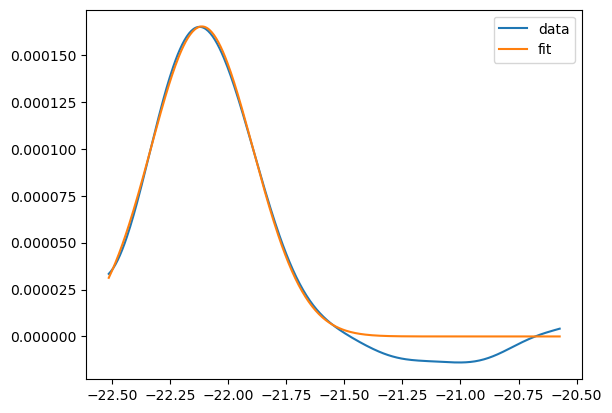

In [18]:
OB_error = dict()
for error in tqdm([0,1e-4,1e-3,1e-2,1e-1,0.12,0.15,0.18,0.2,0.22,0.25,0.28,0.3,0.32],desc='error',colour='red'):
    OB_est = []
    for s in tqdm(range(1,10),desc='sample',colour='blue'):
        path = f"./sample{s}/error{error}"
        time_serial = np.load(f'{path}/time_serial.npy')
        time_serial_recover = TimeSeqRecover(time_serial,7)
        QAF_serial = np.load(f'{path}/QAF_serial.npy')
        QAF_serial_recover = TimeSeqRecover(QAF_serial,7)

        amplitude = []
        for energy in energy_stamp:
            coeffs = []
            for i in range(points+1):
                coeffs.append((width*2/points)*np.exp(-time_stamp[i]**2/(2*sigma**2)+1.j*energy*time_stamp[i])/(sigma*np.sqrt(2*np.pi)))
            amplitude.append(np.array(coeffs)@time_serial_recover)
        np.save(f'{path}/amplitude.npy',amplitude)
        try:
            popt, pcov = curve_fit(gaussian, energy_stamp[100:500], np.real(amplitude[100:500]), p0=[0.1,-21.5,1])
            CI = popt[0]
            plt.cla()
            plt.plot(energy_stamp[100:500], np.real(amplitude[100:500]), label='data')
            plt.plot(energy_stamp[100:500], gaussian(energy_stamp[100:500],*popt), label='fit')
            plt.legend()
            plt.savefig(f'{path}/CI.png')
        except:
            print(f'error={error}, sample={s} not converged')
            CI = 0
        
        Oamplitude = []
        for energy in energy_stamp:
            coeffs = []
            for i in range(points+1):
                coeffs.append((width*2/points)*np.exp(-time_stamp[i]**2/(2*sigma**2)+1.j*energy*time_stamp[i])/(sigma*np.sqrt(2*np.pi)))
            Oamplitude.append(np.array(coeffs)@QAF_serial_recover)
        np.save(f'{path}/Oamplitude.npy',Oamplitude)
        try:
            popt, pcov = curve_fit(gaussian, energy_stamp[100:500], np.real(Oamplitude[100:500]), p0=[0.1,-21.5,1])
            CO = popt[0]
            plt.cla()
            plt.plot(energy_stamp[100:500], np.real(Oamplitude[100:500]), label='data')
            plt.plot(energy_stamp[100:500], gaussian(energy_stamp[100:500],*popt), label='fit')
            plt.legend()
            plt.savefig(f'{path}/CO.png')
        except:
            print(f'error={error}, sample={s} not converged')
            CO = 0

        if abs(CI) < 1e-5:
            OB_est.append(CO/1e-5)
        else:
            OB_est.append(CO/CI)
    
    OB_error[f'error{error}'] = (np.mean(OB_est),np.sqrt(np.var(OB_est, ddof=1)))